In [21]:
import matplotlib.pyplot as plt
import hail as hl

In [22]:
hl.init()

FatalError: Hail has already been initialized, restart session or stop Hail to change configuration.

In [3]:
colors = {'1' : "#08ad4d", '2' : "#cc0648", '3' : "#bbdd11", '4' : "#4a87d6", 
                '5' : "#6f50b7", '6' : "#e0c10f", '7' : "#d10456", '8' : "#2779d8", 
                '9' : "#9e0631", '10' : "#5fcc06", '11' : "#4915a8", '12' : "#0453d3", 
                '13' : "#7faf26", '14' : "#d17b0c", '15' : "#526d13", '16' : "#e82019", 
                '17' : "#125b07", '18' : "#12e2c3", '19' : "#914ae2", '20' : "#95ce10", 
                '21' : "#af1ca8", '22' : "#eaca3a", 'X' : "#1c8caf"}

In [6]:
colors = {}
for i in range(1,23):
    if i%2==0:
        colors[str(i)] = '#0e6d19'
    else:
        colors[str(i)] = "#000000"
colors['X'] = "#000000"

background = '#e8ebef'

In [7]:
keys = list(colors.keys())
c = list(colors.values())
x = [i for i in range(1,24)]
y = [0 for i in range(0,23)]


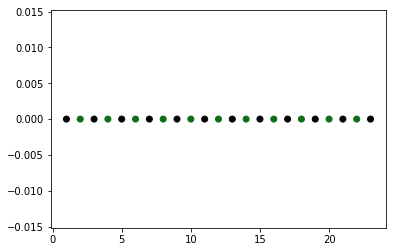

In [8]:
plt.scatter(x, y, c=c)
plt.show()

In [ ]:
# gwas
ds = hl.read_matrix_table('tutorial_data/1kg.mt')
table = (hl.import_table('tutorial_data/1kg_annotations.txt', impute=True)
         .key_by('Sample'))
ds = ds.annotate_cols(**table[ds.s])
gwas = hl.linear_regression(y=ds.CaffeineConsumption, x=ds.GT.n_alt_alleles(), covariates=[1.0])
pca_eigenvalues, pca_scores, _ = hl.hwe_normalized_pca(ds.GT)
cds = ds.annotate_cols(pca = pca_scores[ds.s])
linear_regression_results = hl.linear_regression(
    y=cds.CaffeineConsumption, x=cds.GT.n_alt_alleles(),
    covariates=[1.0, cds.isFemale, cds.pca.scores[0], cds.pca.scores[1], cds.pca.scores[2]])
caffeine_pval_tbl = (linear_regression_results
       .select_rows(linear_regression_results.linreg.p_value)
       .select_entries()
       .rows())
caffeine = caffeine_pval_tbl.annotate_globals(color_dict = colors)
caffeine = (caffeine
            .annotate(
                global_position = caffeine.locus.global_position(),
                neg_log_pval = -hl.log(caffeine.p_value),
                color = caffeine.color_dict[caffeine.locus.contig])
           .select('global_position','p_value','neg_log_pval', 'color')
           .rename({'p_value':'pval'}))

In [ ]:
#SKIP already written
ht_with_pheno = caffeine_pval_tbl.annotate(
    phenotype='caffeine_consumption')
print(ht_with_pheno.count())
mt = ht_with_pheno.distinct().to_matrix_table(['locus','alleles'],['phenotype'])
mt.count()
mt.describe()
mt.write('/Users/maccum/manhattan_data/raw/caffeine_mt', overwrite=True)

In [ ]:
manhat_mt = hl.read_matrix_table('/Users/maccum/manhattan_data/with_plot_fields/caffeine_mt')
collected = manhat_mt.entries().collect()

In [ ]:
gp = []
nlp = []
color_list = []

In [11]:
for i in range(0, len(collected)):
    gp.append(collected[i].global_position)
    nlp.append(collected[i].neg_log_pval)
    color_list.append(colors[collected[i].locus.contig])

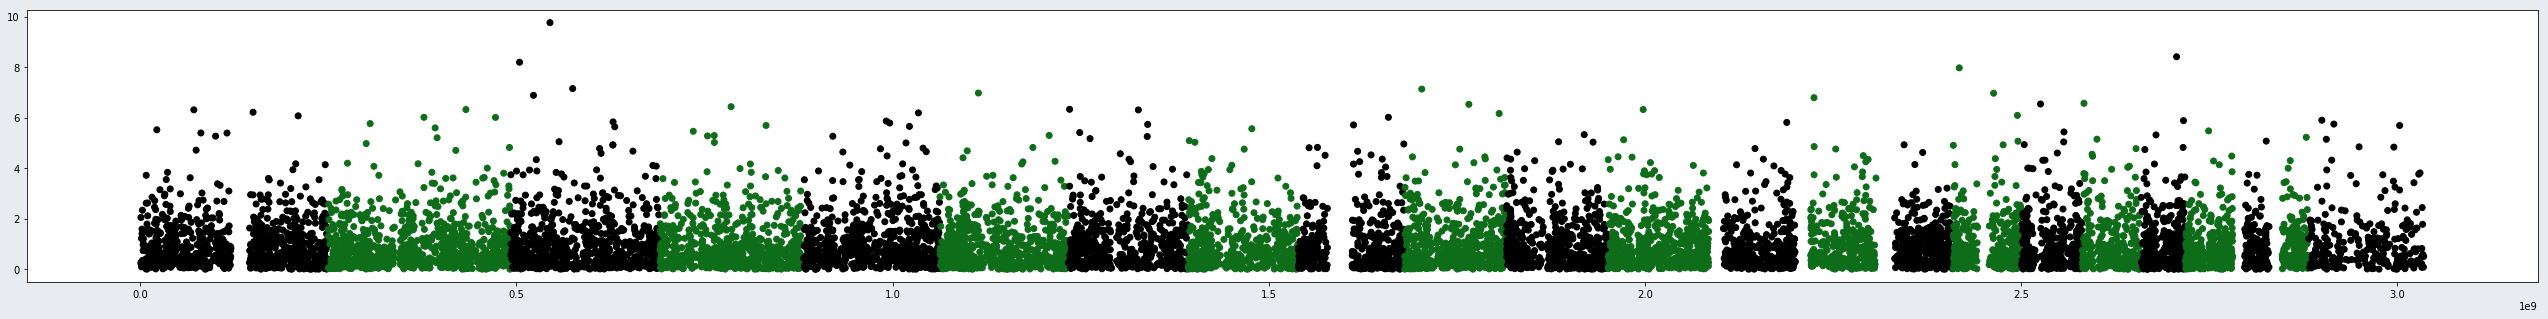

In [20]:
fig = plt.figure(figsize=(45,5))
fig.set_facecolor(background)
plt.scatter(gp, nlp, c=color_list)
plt.savefig('color_test.png', transparent=True)
plt.show()
plt.close()

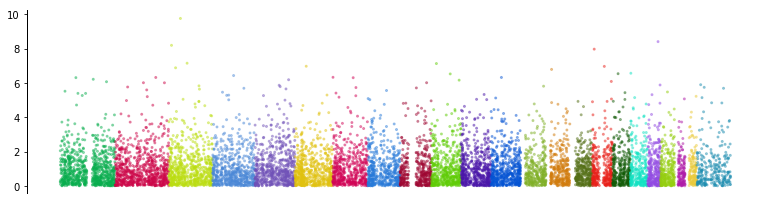

In [57]:
# AXES


from matplotlib.lines import Line2D

fig = plt.figure(figsize=(10.24, 2.56))
ax = fig.add_axes([0, 0, 1, 1])
#ax.set_axis_off()
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(True)

ax.scatter(gp, nlp, c=color_list, s=4, alpha=0.4)
#ax.set_ylim(y_range)
#ax.set_xlim(x_range)

xmin, xmax = ax.get_xaxis().get_view_interval()
ymin, ymax = ax.get_yaxis().get_view_interval()
ax.add_artist(Line2D((xmin, xmin), (ymin, ymax), color='black', linewidth=2))

#plt.savefig(tile_path, dpi=100)
plt.show()
plt.close()

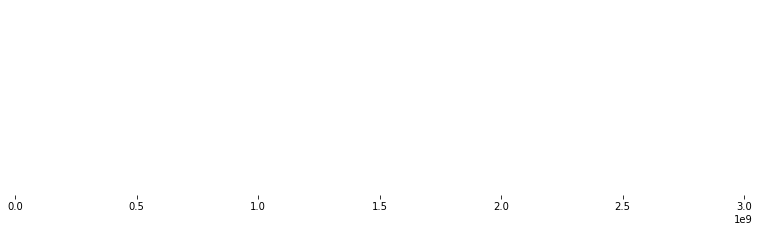

In [41]:
y_range = [min(nlp), max(nlp)]
x_range = [min(gp), max(gp)]

fig = plt.figure(figsize=(10.24, 2.56))
ax = fig.add_axes([0, 0, 1, 1])
#ax.set_axis_off()
ax.set_frame_on(False)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(True)
#ax.scatter(gp, nlp, c=color_list, s=4, alpha=0.4)
ax.set_ylim(y_range)
ax.set_xlim(x_range)
#plt.savefig(tile_path, dpi=100)
plt.show()
plt.close()

In [6]:
print(len(collected))

10879


In [12]:
manhat_mt_ents = manhat_mt.entries()
manhat_mt_ents.describe()
downsampled_array = manhat_mt_ents.aggregate(
    hl.agg.downsample(
        manhat_mt_ents.global_position, manhat_mt_ents.neg_log_pval, n_divisions=500))

----------------------------------------
Global fields:
    'gp_range': struct {
        min: int32, 
        max: int64
    } 
----------------------------------------
Row fields:
    'locus': locus<GRCh37> 
    'alleles': array<str> 
    'global_position': int64 
    'color': str 
    'phenotype': str 
    'min_nlp': float64 
    'max_nlp': float64 
    'p_value': float64 
    'neg_log_pval': float64 
----------------------------------------
Key: ['locus', 'alleles', 'phenotype']
----------------------------------------


In [14]:
len(downsampled_array)

8722

In [34]:
gps_to_keep = hl.array([gp for (gp, nlp, _) in downsampled_array])

In [35]:
filt_ht = manhat_mt_ents.filter(gps_to_keep.contains(manhat_mt_ents.global_position))

In [36]:
filt_ht.count()

8722

In [37]:
down2 = filt_ht.aggregate(
    hl.agg.downsample(
        filt_ht.global_position, filt_ht.neg_log_pval, n_divisions=500))

In [38]:
len(down2)

8349

In [39]:
down3 = filt_ht.aggregate(
    hl.agg.downsample(
        filt_ht.global_position, filt_ht.neg_log_pval, n_divisions=256*256))

In [40]:
len(down3)

8722